In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .config('spark.jars', '/opt/dev/target/ml-on-spark-1.0.jar')\
    .getOrCreate()

print('pyspark ready ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [2]:
train = spark.read.load("/data/lastfm-dataset-360K/coo-data-train.parquet")
train.printSchema()
print(train.rdd.getNumPartitions())

root
 |-- userId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- listenCount: float (nullable = true)
 |-- scaled-by-user: float (nullable = true)
 |-- scaled-by-artist: float (nullable = true)

8


In [4]:
%autoreload
from mlonspark.alternating_least_square import AlternatingLeastSquare
from pyspark.ml.recommendation import ALS

als = AlternatingLeastSquare()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("scaled-by-artist")\
    .setAlpha(1.0)\
    .setNumUserBlocks(7)\
    .setNumItemBlocks(7)\
    .setMaxIter(10)\

In [21]:
model = als.fit(train)
print(model)

AlternatingLeastSquare_485f9a118eccbbbf030d


In [18]:
test = spark.read.load("/data/lastfm-dataset-360K/coo-data-test.parquet")
print(test.rdd.getNumPartitions())

7


In [23]:
predictions = model.transform(test)
predictions.printSchema()
predictions.show(10)

root
 |-- userId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- listenCount: float (nullable = true)
 |-- prediction: float (nullable = false)

+------+--------+-----------+-------------+
|userId|artistId|listenCount|   prediction|
+------+--------+-----------+-------------+
| 74849|     148|      146.0| 7.8676455E-4|
|194327|     148|        2.0|-7.3124675E-6|
|117955|     148|       16.0| 3.8636295E-4|
|328713|     148|       82.0|-2.2494198E-4|
|233446|     148|      107.0|  5.006935E-4|
|310068|     148|      127.0|  5.214018E-5|
|133763|     148|       35.0| -7.694325E-4|
|214964|     148|      115.0| 0.0012114723|
|335475|     148|        4.0|  7.685114E-4|
|179718|     148|      218.0|-6.8790476E-5|
+------+--------+-----------+-------------+
only showing top 10 rows



In [1]:
nan = predictions.where(isnan(col("listenCount")))  
nan.count()

NameError: name 'predictions' is not defined

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("listenCount")\
    .setPredictionCol("prediction")

predictionsFiltered = predictions.where(~isnan(col("prediction")))                                
rmse = evaluator.evaluate(predictionsFiltered)

print("RMSE = %f" % rmse)

RMSE = 662.249448


In [25]:
#histogram = train.select(train["listenCount"]).rdd.map(lambda x : x[0]).histogram(100)

<BarContainer object of 100 artists>

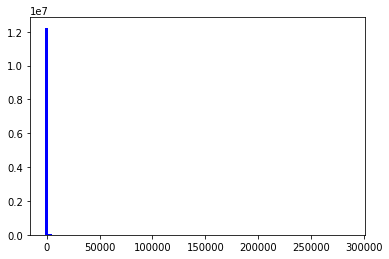

In [26]:
#%matplotlib inline
#
#import numpy as np
#import matplotlib.pyplot as plt
#
#def create_hist(rdd_histogram_data):
#    """Given an RDD.histogram, plot a pyplot histogram"""
#    heights = np.array(rdd_histogram_data[1])
#    full_bins = rdd_histogram_data[0]
#    mid_point_bins = full_bins[:-1]
#    widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
#    bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
#    return bar
#
#create_hist(histogram)

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("scaled-by-artist")\
    .setPredictionCol("prediction")

pipeline = Pipeline().setStages([als])
params = ParamGridBuilder()\
    .addGrid(als.maxIter, range(2, 20, 2))\
    .build()    

cv = TrainValidationSplit()\
    .setTrainRatio(0.75)\
    .setEstimator(als)\
    .setEstimatorParamMaps(params)\
    .setEvaluator(evaluator)

model = cv.fit(train)

In [10]:
model.validationMetrics

[1.8279140365616355,
 1.802922564477033,
 1.8027585545333622,
 1.8032802236657812,
 1.8035988130927716,
 1.803760017886655,
 1.8038397831906332,
 1.8038805254310877,
 1.8039024605728446]

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


pipeline = Pipeline().setStages([als])
params = ParamGridBuilder()\
    .addGrid(als.rank, range(2, 20, 2))\
    .build()    

cv = TrainValidationSplit()\
    .setTrainRatio(0.75)\
    .setEstimator(als)\
    .setEstimatorParamMaps(params)\
    .setEvaluator(evaluator)

rankModel = cv.fit(train)

In [13]:
rankModel.validationMetrics

[1.82086030778711,
 1.814702969321573,
 1.8096042610748342,
 1.8062740882891426,
 1.8035988130927716,
 1.801514357783253,
 1.799578346927742,
 1.7979869543175757,
 1.7965817918740603]

In [37]:
%autoreload
from mlonspark.alternating_least_square import AlternatingLeastSquare
from pyspark.ml.recommendation import ALS

#    .setImplicitPrefs(False)\
als = AlternatingLeastSquare()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("scaled-by-artist")\
    .setNumUserBlocks(7)\
    .setNumItemBlocks(7)\
    .setMaxIter(10)\
    .setRank(15)

model = als.fit(train)
print(model)



AlternatingLeastSquare_443aba316227441f86a5


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'AlternatingLeastSquare' object has no attribute '_java_obj'


In [32]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

predictions = model.transform(test)

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("scaled-by-artist")\
    .setPredictionCol("prediction")

predictionsFiltered = predictions.where(~isnan(col("prediction")))                                
rmse = evaluator.evaluate(predictionsFiltered)

print("RMSE = %f" % rmse)

RMSE = 0.940904
